In [1]:
import sys
sys.path.append('../src')
%load_ext autoreload
%autoreload 2
from predict_test_img import *
from character_recognition import *

import config
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
text_model = pickle.load(open(config.TEXT_MODEL_PATH, 'rb'))  # get model
character_model = load_model()
dictionary = np.load(config.DICT_PATH)  # get dictionary
# image_files = glob.glob(os.path.join(config.TEST_IMAGE_PATH, '*.jpg'))

f = 'test4.png'
image_file = os.path.join(config.TEST_IMAGE_PATH, f)
img = cv2.imread(image_file)



In [3]:
try:
    predicted_layers = [
        [img,
        np.load(f + 'predictions.npy')]
    ]
except Exception as e:
    print(e)
    predicted_layers = get_prediction_values(img, text_model, 4)
    np.save(f + 'predictions.npy', predicted_layers[0][1])
    
predicted_layers[0][1][:,:32] *= np.hstack([[40/i]*4 for i in range(8,40, 4)])

predicted_layers[0][0] = cv2.cvtColor(predicted_layers[0][0], cv2.COLOR_BGR2RGB)

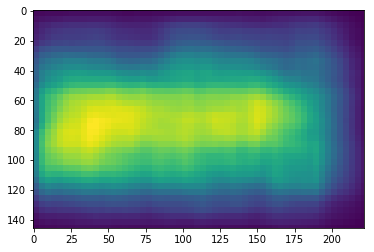

In [4]:
len(predicted_layers)


plt.imshow(predicted_layers[0][1])


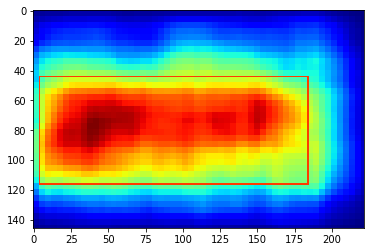

In [50]:
bboxes = bounding_boxes(predicted_layers[0][1], 36)

#probabilities = cv2.filter2D(predicted_layers[0][1],-1,kernel)
probabilities = predicted_layers[0][1].copy()

for bbox in bboxes:
    #cv2.rectangle(probabilities, (0, 100), (150, 200), (50,0,0))
    cv2.rectangle(probabilities, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (50,0,0))
#probabilities[predicted_layers[0][1] < 38] = 0
plt.imshow(probabilities, cmap=plt.get_cmap('jet'))
plt.imsave('predictionwithbbox.png', probabilities, cmap=plt.get_cmap('jet'))

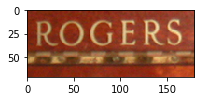

In [49]:
fig, axes = plt.subplots(nrows=len(bboxes), ncols=1, figsize=(3, 3*len(bboxes)))
for i,bbox in enumerate(bboxes):
    if len(bboxes) == 1:
        ax = axes
    else:
        ax = axes[i]
    ax.imshow(predicted_layers[0][0][bbox[0]:bbox[2], bbox[1]:bbox[3]])
    plt.imsave('extracted_patch.png', predicted_layers[0][0][bbox[0]:bbox[2], bbox[1]:bbox[3]])

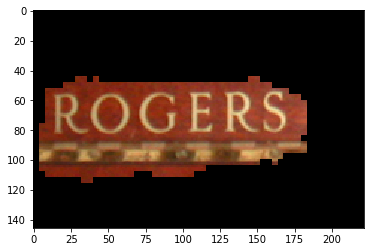

In [48]:

img = predicted_layers[0][0].copy()

img[predicted_layers[0][1] < 36] = 0
plt.imshow(img)


In [9]:
%%time 
from character_recognition import character_recognition
texts = character_recognition(predicted_layers[0][0], predicted_layers[0][1], dictionary, character_model, 36)


INFO:root:Start predicting bbox
INFO:root:0/6109 prediction of window in bbox
INFO:root:100/6109 prediction of window in bbox
INFO:root:200/6109 prediction of window in bbox
INFO:root:300/6109 prediction of window in bbox
INFO:root:Yielded 418 and missed 0 windows
INFO:root:400/6109 prediction of window in bbox


CPU times: user 837 ms, sys: 1.77 s, total: 2.61 s
Wall time: 4min 6s


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 56 but corresponding boolean dimension is 72
  app.launch_new_instance()


255

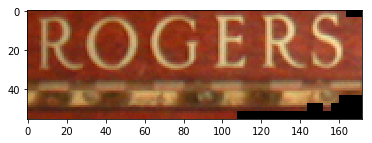

In [10]:
bbox = bboxes[0]
bbox_img = img[bbox[0]: bbox[2], bbox[1]: bbox[3]].copy()
bbox_img[texts[0]['probabilities']>1] = (1, 0, 0)
fig, ax = plt.subplots()
ax.imshow(bbox_img)

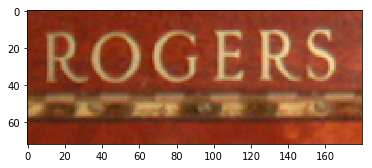

In [39]:
bboxes = bounding_boxes(predicted_layers[0][1], 36)
fbbox = bboxes[0]
bbox_img = predicted_layers[0][0][fbbox[0]: fbbox[2], fbbox[1]: fbbox[3]].copy()
plt.imshow(bbox_img)

In [40]:
texts[0]['probabilities'].sum(axis=1)

array([  9.54672299,   0.        ,   0.        ,   0.        ,
        13.07883886,   0.        ,   0.        ,   0.        ,
        18.18157764,   0.        ,   0.        ,   0.        ,
        10.54553896,   0.        ,   0.        ,   0.        ,
         9.44238978,   0.        ,   0.        ,   0.        ,
        11.36806263,   0.        ,   0.        ,   0.        ,
        10.54970296,   0.        ,   0.        ,   0.        ,
        12.06157716,   0.        ,   0.        ,   0.        ,
        10.85228996,   0.        ,   0.        ,   0.        ,
        12.93215728,   0.        ,   0.        ,   0.        ,
        12.21722778,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.  

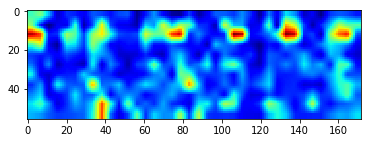

In [45]:
fig, ax = plt.subplots(figsize=(6, 2))
ii = texts[0]['probabilities'].copy()
ii[ii > 0]
ii=ii[~np.all(ii == 0, axis=1)]
ii=ii[:,~np.all(ii == 0, axis=0)]
ii=cv2.resize(ii, dsize=img[bbox[0]:bbox[2], bbox[1]:bbox[3]].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
#ax.imshow(img[bbox[0]:bbox[2], bbox[1]:bbox[3]])
# out = img[bbox[0]:bbox[2], bbox[1]:bbox[3]].copy()
# out[:,:,0] += (200*ii).astype('uint8')
ax.imshow(ii, cmap=plt.get_cmap('jet'))
plt.imsave('character_heatmap.png', ii, cmap=plt.get_cmap('jet'))

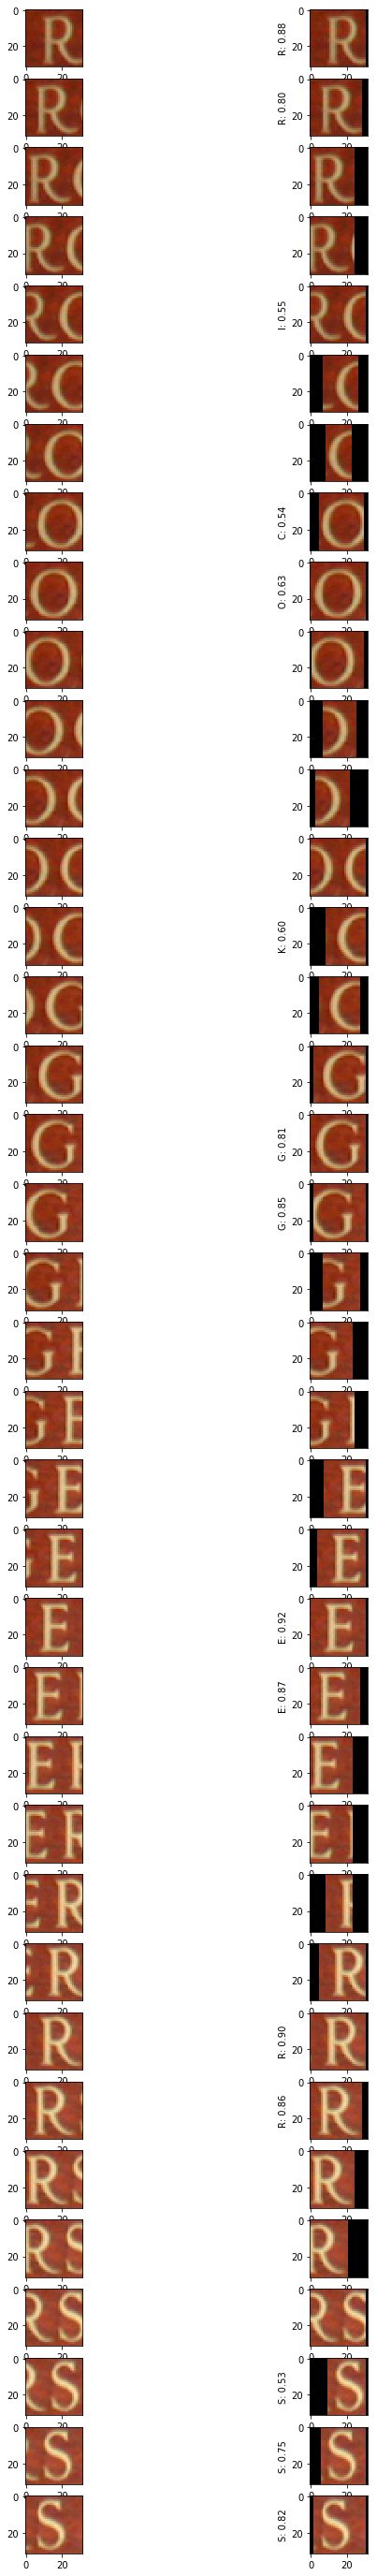

In [95]:
step_size=4
fig, axes = plt.subplots(nrows=(bbox_img.shape[1]-32)//step_size, ncols=2, figsize=(10,50))
y=8
for i in range(0, bbox_img.shape[1]-32, step_size):
    
    axes[i//step_size,0].imshow(bbox_img[y:y+32, i:i+32, :])

    cut = cut_character(bbox_img[y:y+32, i:i+32, :])

def predict_wordfile(filename, model, dictionary):
    '''
    Load a file and predict the whole image as word
    '''
    raise ValueError('Not implemented...')

    features = get_features_for_window(cut)[1].reshape(1, -1)
    c=character_model.predict(features)[0]
    p=max(character_model.predict_proba(features)[0])

    axes[i//step_size,1].imshow(cut)

    if p > 0.5:
        axes[i//step_size,1].set_ylabel('{}: {:.2f}'.format(c, p))

fig.savefig('sliding_window_character_prediction_rogers.png', dpi=200)

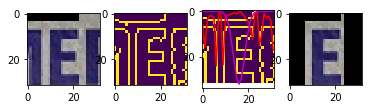

In [70]:
fig, ax = plt.subplots(ncols=4)
i=40
window = bbox_img[:, i:i+32, :]
ax[0].imshow(window)
cut = cut_character(window)

from scipy.stats import norm

gauss = norm.pdf(list(range(32)), loc=16, scale=2.5)
gauss = (1-(gauss / gauss.max()))

threshold1 = 100
threshold2 = 200

canny = cv2.Canny(np.uint8(window*255), threshold1, threshold2)
canny[canny > 0] = 1

ax[1].imshow(canny)

ax[2].imshow(canny)
ax[2].plot(list(range(32)), (canny.sum(axis=0))*gauss, color='r')
ax[2].plot(list(range(32)), 32-gauss*32, color='m')bbox_img.shape[1]-32

#x1 = ((32-canny.sum(axis=0))*gauss)[:16].argmax()
#x2 = ((32-canny.sum(axis=0))*gauss)[16:].argmax()+16
#window = np.copy(window)
#window[:, :x1] = 0
#window[:, x2:] = 0
#return window
    

features = get_features_for_window(cut)[1].reshape(1, -1)
c=character_model.predict(features)[0]
p=max(character_model.predict_proba(features)[0])

ax[3].imshow(cut)
fig.savefig('cut_character_2.png', dpi=400)

In [38]:
texts[0]

{'characters': array([['D', '', '', ..., '', '', ''],
        ['', '', '', ..., '', '', ''],
        ['', '', '', ..., '', '', ''],
        ..., 
        ['', '', '', ..., '', '', ''],
        ['', '', '', ..., '', '', ''],
        ['', '', '', ..., '', '', '']], 
       dtype='<U1'),
 'probabilities': array([[ 0.44639812,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]),
 'x': 4,
 'y': 44}

In [56]:
cc=texts[0]['characters'].copy()
cc=cc[~np.all(cc == '', axis=1)]
cc=cc[:,~np.all(cc == '', axis=0)]

In [57]:
cc

array([['D', 'D', 'i', 'i', 'M', 'r', 'n', 'c', 'n', 'i', 'i', 'i', 'E',
        'r', 'C', 'C', 'E', 'i', 'A', 't', 'I', 'G', 'r', 'E', 'S', 'N',
        't', 'I', 'D', 'D', 'W', 'W', 'm', 'b', 'S', 'S', 'c', 'C'],
       ['R', 'R', '0', 'I', 'I', 'r', 'C', 'C', 'O', 'D', 'y', 'y', 'H',
        'r', 'r', 'C', 'G', 'G', 'H', 'H', 'I', 's', 'F', 'E', 'E', 'A',
        'I', 'I', 'J', 'R', 'R', 'Y', 'I', 'S', 'S', 'S', 's', 'H'],
       ['R', 'R', 'L', 'L', 'I', 'K', 'C', 'C', 'O', 'J', 'y', 'y', 'n',
        'K', 'C', 'C', 'G', 'G', 'H', 'y', 'p', 'J', 'E', 'E', 'E', 'E',
        '3', 'I', 'R', 'R', 'R', 'a', 'a', 's', 'S', 'S', 'S', 'T'],
       ['R', 'R', 'L', 'I', 'I', 'K', 'O', 'C', 'e', 'D', 'J', 'X', 'A',
        'K', 'C', 'C', 'e', 'G', 's', 'i', 'N', 'I', 'P', 'P', 'b', 't',
        'H', 'I', 'l', 'h', 'k', 't', 'i', 'H', 'S', 'S', 'S', 'y'],
       ['J', 'K', 'k', 't', 'U', 'J', 's', 'L', 'O', '2', 'k', 'N', 'A',
        'J', 'V', 'L', 'S', 'e', 'i', '4', 'A', 'L', 'L', 'K', 'L',

/usr/lib/python3.6/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


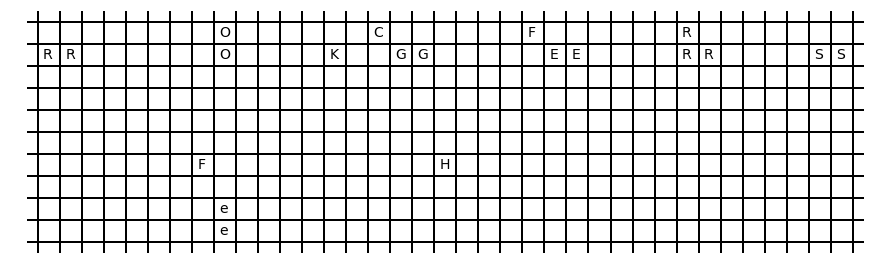

In [91]:
import matplotlib

ii = texts[0]['probabilities'].copy()
ii=ii[~np.all(ii == 0, axis=1)]
ii=ii[:,~np.all(ii == 0, axis=0)]

# make an empty data set
data = np.ones(cc.shape) * np.nan
# make a figure + axes
fig, ax = plt.subplots(1, 1, figsize=(15,5))
# make color map
my_cmap = matplotlib.colors.ListedColormap(['r', 'g', 'b'])
# set the 'bad' values (nan) to be white and transparent
my_cmap.set_bad(color='w', alpha=0)
# draw the grid
for y, x in np.ndindex(*cc.shape):
    if ii[y,x] > 0.6:
        ax.text(x+0.24,y-0.3, cc[y,x], fontsize=14)
    ax.axhline(y, lw=2, color='k', zorder=5)
    ax.axvline(x, lw=2, color='k', zorder=5)
# draw the boxes
ax.imshow(data, interpolation='none', cmap=my_cmap,  zorder=0)
# turn off the axis labels
ax.axis('off')

plt.savefig('character_map.png')